# COVID-19 Detection Model

In [5]:
import os
import shutil
import kagglehub
mehradaria_covid19_lung_ct_scans_path = kagglehub.dataset_download('mehradaria/covid19-lung-ct-scans')

print('Data source import complete.')

D:\Anaconda\envs\tensorflow\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data source import complete.


In [ ]:
!pip install kagglehub

In [6]:
mehradaria_covid19_lung_ct_scans_path

'C:\\Users\\bhavi\\.cache\\kagglehub\\datasets\\mehradaria\\covid19-lung-ct-scans\\versions\\1'

In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras import layers
tf.__version__

'2.15.0'

Importing data

In [8]:
import os
import pathlib
files = os.listdir(mehradaria_covid19_lung_ct_scans_path)
data_dir = os.path.join(mehradaria_covid19_lung_ct_scans_path, files[0])
data_dir = pathlib.Path(data_dir).with_suffix('')
files = os.listdir(data_dir)
files

['COVID-19', 'Non-COVID-19']

In [ ]:
print(tf.config.list_physical_devices('TPU'))

[PhysicalDevice(name='/physical_device:TPU:0', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:1', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:2', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:3', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:4', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:5', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:6', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:7', device_type='TPU')]


In [9]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

8439


In [10]:
covid = list(data_dir.glob('COVID-19/*'))
image = PIL.Image.open(str(covid[1]))
np.array(image)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [11]:
batch_size = 32
img_height = 210
img_width = 210
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       validation_split = 0.2,
                                                       subset = 'training',
                                                       shuffle = True,
                                                       seed=123,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                       )

Found 8439 files belonging to 2 classes.
Using 6752 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       validation_split = 0.2,
                                                       subset = 'validation',
                                                       seed=123,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                       )

Found 8439 files belonging to 2 classes.
Using 1687 files for validation.


In [13]:
classes = train_ds.class_names
classes

['COVID-19', 'Non-COVID-19']

In [14]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches//5)
val_ds = val_ds.skip(val_batches//5)

In [15]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 43
Number of test batches: 10


In [16]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip('horizontal_and_vertical', input_shape=(img_height, img_width, 3)),
])

####Model Creation

In [ ]:
num_classes = len(classes)
model = tf.keras.Sequential([
        data_augmentation,
        layers.Rescaling(1./255),
        layers.Conv2D(filters=32, kernel_size=3, padding='same',activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
])

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 210, 210, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 210, 210, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 210, 210, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 105, 105, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 105, 105, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 52, 52, 64)        0         
 g2D)                                                 

####Model Training

In [ ]:
epochs=10
history=model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/10
211/211 [==============================] - 108s 506ms/step - loss: 0.2714 - accuracy: 0.9017 - val_loss: 0.1998 - val_accuracy: 0.9298
Epoch 2/10
211/211 [==============================] - 107s 508ms/step - loss: 0.1565 - accuracy: 0.9440 - val_loss: 0.1102 - val_accuracy: 0.9707
Epoch 3/10
211/211 [==============================] - 107s 508ms/step - loss: 0.1090 - accuracy: 0.9673 - val_loss: 0.0795 - val_accuracy: 0.9751
Epoch 4/10
211/211 [==============================] - 106s 504ms/step - loss: 0.0806 - accuracy: 0.9759 - val_loss: 0.0892 - val_accuracy: 0.9693
Epoch 5/10
211/211 [==============================] - 107s 508ms/step - loss: 0.0668 - accuracy: 0.9794 - val_loss: 0.0553 - val_accuracy: 0.9810
Epoch 6/10
211/211 [==============================] - 107s 509ms/step - loss: 0.0543 - accuracy: 0.9840 - val_loss: 0.0358 - val_accuracy: 0.9876
Epoch 7/10
211/211 [==============================] - 107s 508ms/step - loss: 0.0375 - accuracy: 0.9890 - val_loss: 0.0293 -

####Evaluation of the model on Test Dataset

In [ ]:
model.evaluate(test_ds)

10/10 [==============================] - 1s 89ms/step - loss: 0.0247 - accuracy: 0.9906


[0.024652190506458282, 0.9906250238418579]

###Visualising Accuracy and Loss

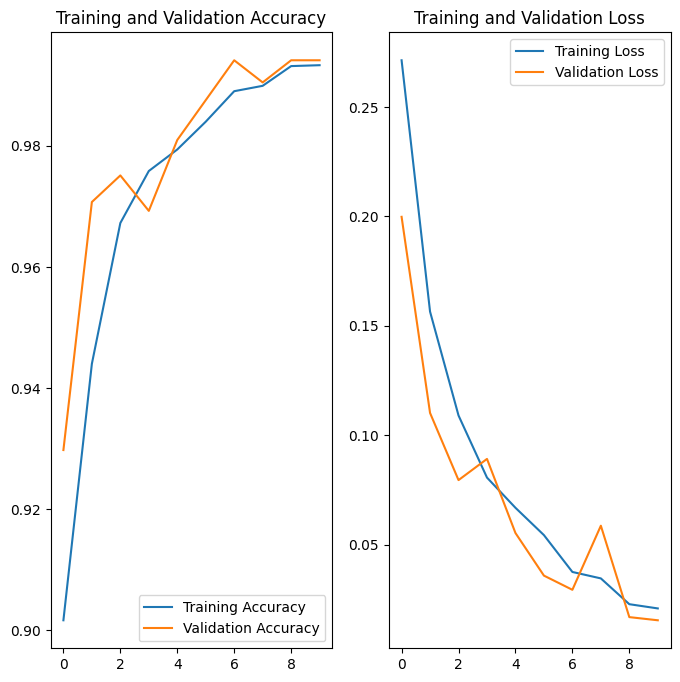

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####Saving the model

In [ ]:
model.save("trained_model.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import json
with open('training_hist.json', 'w') as f:
  json.dump(history.history, f)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
new_model = tf.keras.models.load_model('new_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 210, 210, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 210, 210, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 210, 210, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 105, 105, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 105, 105, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 52, 52, 64)        0         
 g2D)                                                 

###Analyzing Performance

In [14]:
test_image = "Test/COVID.png"
image = tf.keras.preprocessing.image.load_img(test_image,target_size=(210,210))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr]) #convert single image to batch
predictions = new_model.predict(input_arr)
predictions

1/1 [==============================] - 0s 50ms/step


array([[0.00101216]], dtype=float32)

In [18]:
y_true=[]
for x, y in test_ds:
  for i in y:
    y_true.append(i.numpy())
y_true = np.array(y_true)
y_true

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,

In [22]:
y_predict = new_model.predict(test_ds)

10/10 [==============================] - 2s 235ms/step


In [23]:
for i in range(len(y_predict)):
  if y_predict[i] > 0.5:
    y_predict[i] = 1
  else:
    y_predict[i] = 0
y_predict = y_predict.reshape(-1,)
y_predict = y_predict.astype('int32')
y_predict

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,

In [ ]:
!pip install scikit-learn

In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_predict, target_names=classes))

              precision    recall  f1-score   support

    COVID-19       0.99      1.00      0.99       275
Non-COVID-19       0.98      0.93      0.95        45

    accuracy                           0.99       320
   macro avg       0.98      0.96      0.97       320
weighted avg       0.99      0.99      0.99       320



In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_predict)
print(cm)

[[274   1]
 [  3  42]]


In [ ]:
!pip install seaborn

Text(0.5, 1.0, 'Confusion Matrix')

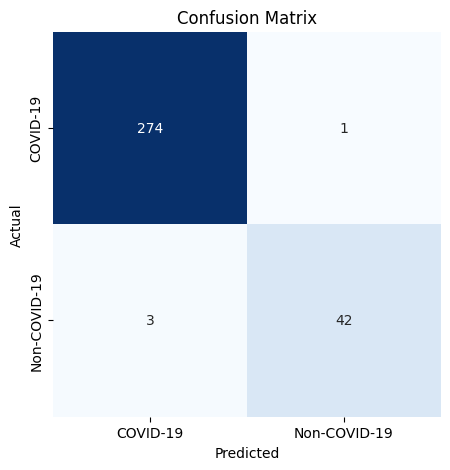

In [31]:
###Confusion Matrix Visualisation
import seaborn as sns
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(np.arange(2) + 0.5, classes)
plt.yticks(np.arange(2) + 0.5, classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")